# 攻守平衡 - 动态仓位管理

### 给定某一期货品种，如rb1801.SHF，假设你穿越回到2017年3月15日（当时收盘价为3305）。仅知
### 道在2017年11月30日会达到4247，但并不知道这期间每天的收盘价。若给定初始资金，你将如何设置杠杆使得最终
### 收益最大？我们分三种情况验证了由凯利公式确定的杠杆比率为最优解：
### a. 初始仓位保持不变（杠杆比率变化）
### b. 杠杆比率保持不变（仓位变化）
### c. 根据risk budget调仓
### d. 每天根据凯利公式调整杠杆比率及仓位

In [1]:
# import sys
# sys.path.append('/home/bliu/pytrade_dir/jaqs')
from jaqs.data.dataservice import RemoteDataService
from jaqs.data.dataview import DataView
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
sns.set_style('darkgrid')
%matplotlib inline

In [3]:
# 如果没有使用quantos金融终端，请自行替换phone,token内容
import os
phone = os.environ.get("QUANTOS_USER")
token = os.environ.get("QUANTOS_TOKEN")

data_config = {
  "timeout": 1800,
  "remote.data.address": "tcp://data.tushare.org:8910",
  "remote.data.username":  phone,
  "remote.data.password":  token}

# 启动DataView，并设置用户名密码
ds = RemoteDataService()
ds.init_from_config(data_config)


Begin: DataApi login 18612562791@tcp://data.tushare.org:8910
    Already login as 18612562791, skip init_from_config


'0,'

### 设置参数

In [4]:
# 策略从20170301开始，利用20170101至20170301期间主力合约rb1705.SHF的收益率计算initretArray
pre_startDate = 20170101
pre_endDate   = 20170314
startDate     = 20170315
endDate       = 20171130

# 设置证券代码
pre_stockCode = 'rb1705.SHF'
stockCode     = 'rb1801.SHF'

# 设置固定长度array保存最近30天的日收益率
windowLength = 30
retArray = np.zeros(windowLength)

# 设置初始资金
initBalance = 1e6

# 设置止损线
margin = 0.1

### 策略初始化

In [5]:
# 利用rb1705.SHF合约初始化retArray
dv = DataView()
props = {'start_date': pre_startDate, 'end_date': pre_endDate, 'symbol': pre_stockCode,
         'freq': 1}
dv.init_from_config(props, data_api=ds)
dv.prepare_data()

Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
Query data - daily fields prepared.
Query instrument info...
Query adj_factor...
Data has been successfully prepared.


In [6]:
# 取出收盘价数据
closeData = dv.get_ts('close')

# 计算日收益率
retData = (closeData.diff()/closeData.shift(1)).dropna()
initretArray = list(retData[pre_stockCode].values[-windowLength:])

In [7]:
# 取rb1801.SHF收盘价
dv = DataView()
props = {'start_date': startDate, 'end_date': endDate, 'symbol': stockCode,
         'freq': 1}
dv.init_from_config(props, data_api=ds)
dv.prepare_data()

Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
Query data - daily fields prepared.
Query instrument info...
Query adj_factor...
Data has been successfully prepared.


In [8]:
# 取出收盘价数据
closeData = dv.get_ts('close')
closeData['date'] = closeData.index
closeData['date'] = closeData['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())
closeArray = closeData[stockCode].values
retArray   = np.diff(np.log(closeArray))
dateList   = np.array(closeData['date'])

### 计算参数

In [9]:
# 根据历史日收益率计算初始mu和sigma
initmu    = (closeArray[-1]/closeArray[0] * 1.0) ** (1.0/len(closeArray)) - 1
initsigma = np.sqrt(np.sum((retArray - 0.0)**2) / len(retArray))

# 计算初始杠杆比率
initLever = initmu/initsigma ** 2

# 设置初始资金
currentBalance = initBalance
# initmu, initsigma, initLever, closeArray[0], closeArray[-1]

### 情况一：初始仓位保持不变
### 根据初始杠杆比率计算仓位，并在策略运行期间保持不变。

In [10]:
# 给定几种初始仓位
initSizeList = [10, 15, 20, 50, 100, 125]
balanceDict = {}
leverDict = {}

In [11]:
for currentSize in initSizeList:
    balanceList = []
    leverList = []
    currentBalance = initBalance
    for i in range(len(closeArray)-22):
        if i == 0:
            # 在策略运行的第一天，以收盘价买入
            lever = closeArray[i] * 10 * currentSize/ currentBalance

            # 原则上应该使用期货的settlement price计算平仓线stoploss，这里我们为了简化使用closing price计算，后面也如此
            stoploss = closeArray[i] * 10 * currentSize * margin
            balanceList.append(currentBalance)
            leverList.append(lever)
        else:
            if currentBalance > stoploss:
                # 计算持仓pnl
                pnl = (closeArray[i] - closeArray[i-1]) * currentSize * 10
                currentBalance += pnl
                stoploss = closeArray[i] * 10 * currentSize * margin                

                if currentBalance > stoploss:
                    # 在初始仓位不变情况下，根据当天的currentBalance计算当前lever
#                     lever = min(currentSize * closeArray[i] * 10/currentBalance, maxlever)
                    lever = currentSize * closeArray[i] * 10/currentBalance
                    balanceList.append(currentBalance)
                    leverList.append(lever)
                else:
                    # 若当天currentBalance小于stoploss，则平仓
                    lever = 0
                    balanceList.append(currentBalance)
                    leverList.append(lever)
            else:
                balanceList.append(currentBalance)
                leverList.append(lever)
#             print currentBalance, currentSize, lever, sigma, closeArray[i]
    balanceDict[currentSize] = balanceList
    leverDict[currentSize] = leverList

In [12]:
# 画图
colormap = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138),   
             (148, 103, 189), (197, 176, 213), (214, 39, 40), (255, 152, 150),(140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

for i in range(len(colormap)):  
    r, g, b = colormap[i]  
    colormap[i] = (r / 255., g / 255., b / 255.)  

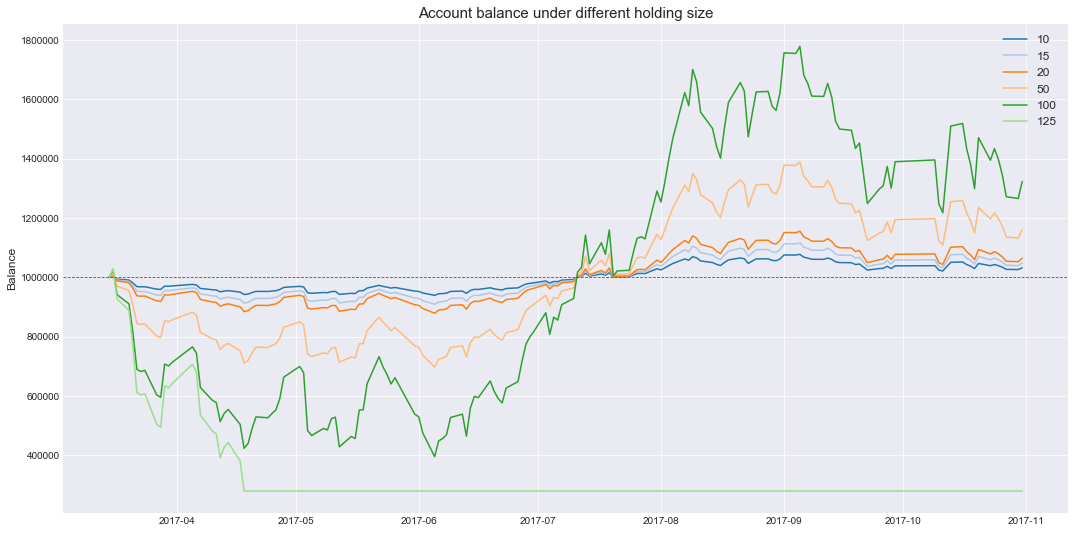

In [13]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(initSizeList)):
#     if initSizeList[i] == optimalSize:
#         labelName = 'optimal'
#     else:
#         labelName = initSizeList[i]
    labelName = initSizeList[i]
    ax1.plot(dateList[:-22], balanceDict[initSizeList[i]], color = colormap[i], label = labelName)
    
ax1.axhline(y = initBalance, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Balance', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Account balance under different holding size', fontsize=15)
plt.show()

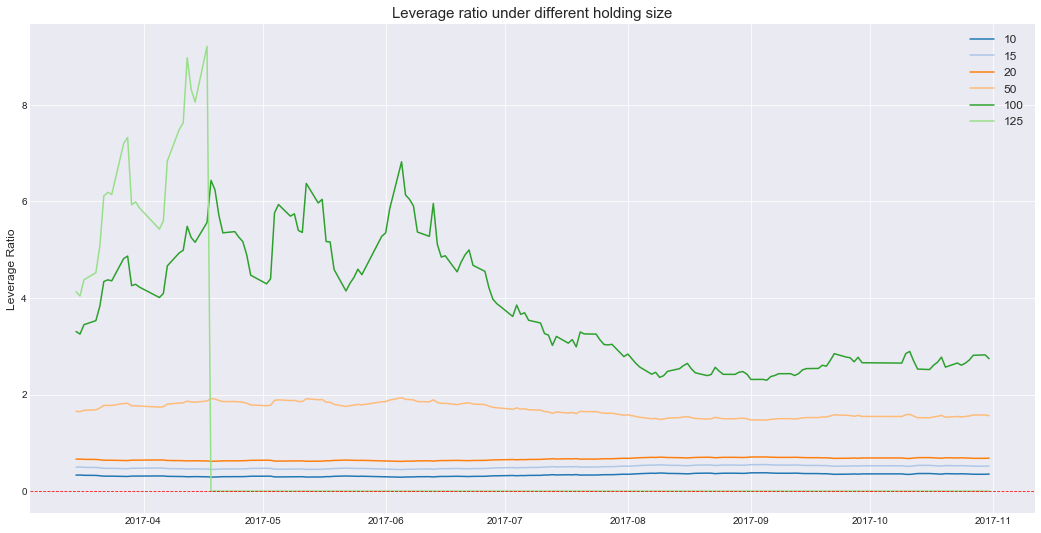

In [14]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(initSizeList)):
#     if initSizeList[i] == optimalSize:
#         labelName = 'optimal'
#     else:
#         labelName = initSizeList[i]
    labelName = initSizeList[i]
    ax1.plot(dateList[:-22], leverDict[initSizeList[i]], color = colormap[i], label = labelName)
ax1.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Leverage Ratio', fontsize = 12)
# ax1.set_yscale('log', basey=10)
plt.legend(fontsize = 12)
# ax2 = ax1.twinx()
# ax2.plot(dateList, closeArray, color = 'red')
# ax2.set_ylabel('Price')
plt.title('Leverage ratio under different holding size', fontsize=15)
plt.show()

In [17]:
# 计算Sharpe ratio
for size in initSizeList:
    retList = [(balanceDict[size][i] - balanceDict[size][i-1])/balanceDict[size][i-1] for i in range(1, len(balanceDict[size]))]
    sharpe = np.mean(retList)/np.std(retList) * np.sqrt(242)
    print("Sharpe ratio is %.4f when holding size is %.2f" % (sharpe, size))

Sharpe ratio is 0.5272 when holding size is 10.00
Sharpe ratio is 0.5511 when holding size is 15.00
Sharpe ratio is 0.5744 when holding size is 20.00
Sharpe ratio is 0.7103 when holding size is 50.00
Sharpe ratio is 0.9853 when holding size is 100.00
Sharpe ratio is -2.2027 when holding size is 125.00


### 情况二：杠杆比率保持不变
### 通过每日调整持仓使杠杆比率在策略运行期间保持不变。

In [18]:
balanceDict = {}
sizeDict = {}
levers = [0.25, 0.5, 1, 2, 4, 6]

In [19]:
for lever in levers:
    balanceList = []
    sizeList = []
    currentBalance = initBalance
    for i in range(len(closeArray)-22):
        if i == 0:
            # 在策略运行的第一天，以收盘价买入
            currentSize = np.floor(currentBalance * lever/(closeArray[i] * 10))
            stoploss = closeArray[i] * 10 * currentSize * margin
            balanceList.append(currentBalance)
            sizeList.append(currentSize)            
        else:
            if currentBalance > stoploss:
                # 计算持仓pnl
                pnl = (closeArray[i] - closeArray[i-1]) * currentSize * 10
                currentBalance += pnl
                stoploss = closeArray[i] * 10 * currentSize * margin

                if currentBalance > stoploss:
                    # 在杠杆比率不变情况下，根据当天的currentBalance调整持仓
                    currentSize = np.floor(currentBalance * lever/(closeArray[i] * 10))
                    balanceList.append(currentBalance)
                    sizeList.append(currentSize)
                else:
                    # 若当天currentBalance小于stoploss，则平仓
                    currentSize = 0
                    balanceList.append(currentBalance)
                    sizeList.append(currentSize)            
            else:
                balanceList.append(currentBalance)
                sizeList.append(currentSize)
#             print currentBalance, currentSize, lever, closeArray[i]
    balanceDict[lever] = balanceList
    sizeDict[lever] = sizeList

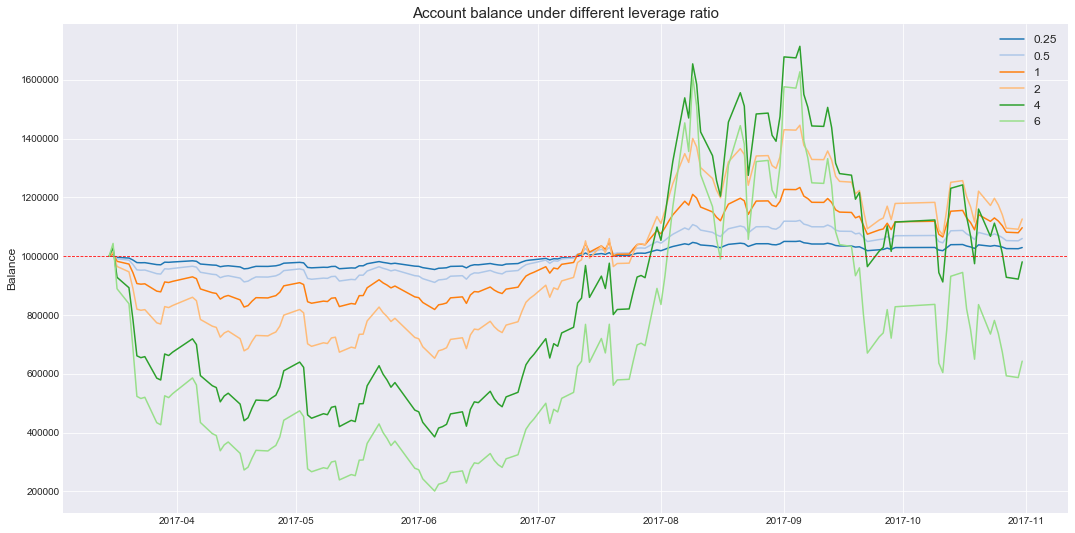

In [20]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(levers)):
    labelName = levers[i]
    ax1.plot(dateList[:-22], balanceDict[levers[i]], color = colormap[i], label = labelName)
ax1.axhline(y = initBalance, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Balance', fontsize = 12)
plt.legend(fontsize = 12)
# ax2 = ax1.twinx()
# ax2.plot(dateList, closeArray, color = 'red')
# ax2.set_ylabel('Price')
plt.title('Account balance under different leverage ratio', fontsize=15)
plt.show()

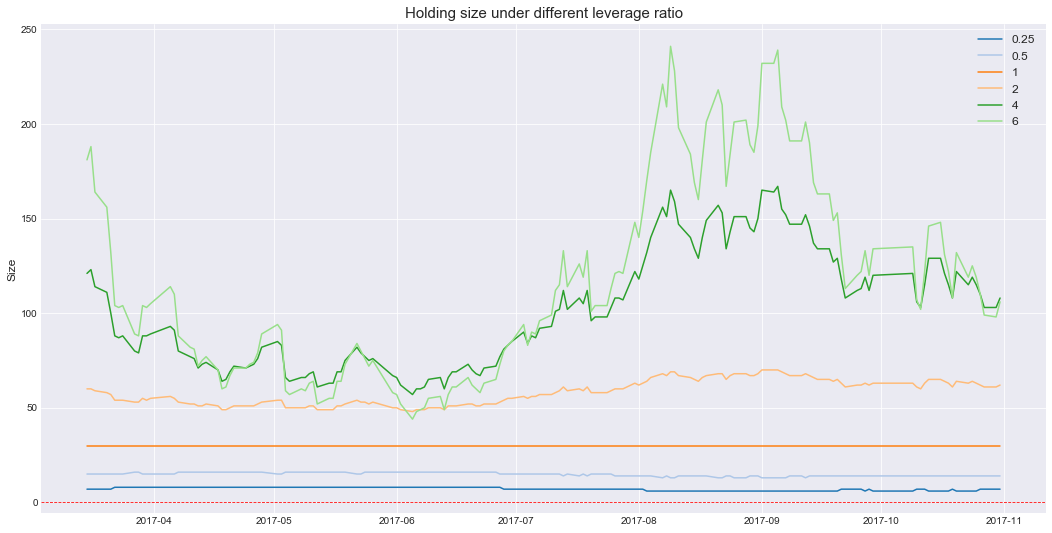

In [21]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(levers)):
    labelName = levers[i]
    ax1.plot(dateList[:-22], sizeDict[levers[i]], color = colormap[i], label = labelName)
ax1.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Size',fontsize = 12)
plt.legend(fontsize = 12)
# ax2 = ax1.twinx()
# ax2.plot(dateList, closeArray, color = 'red')
# ax2.set_ylabel('Price')
plt.title('Holding size under different leverage ratio', fontsize=15)
plt.show()

In [22]:
# 计算Sharpe ratio
for lever in levers:
    retList = [(balanceDict[lever][i] - balanceDict[lever][i-1])/balanceDict[lever][i-1] for i in range(1, len(balanceDict[lever]))]
    sharpe = np.mean(retList)/np.std(retList) * np.sqrt(242)
    print("Sharpe ratio is %.4f when leverage ratio is %.2f"% (sharpe, lever))

Sharpe ratio is 0.6523 when leverage ratio is 0.25
Sharpe ratio is 0.6773 when leverage ratio is 0.50
Sharpe ratio is 0.6201 when leverage ratio is 1.00
Sharpe ratio is 0.6140 when leverage ratio is 2.00
Sharpe ratio is 0.6160 when leverage ratio is 4.00
Sharpe ratio is 0.6102 when leverage ratio is 6.00


### 情况三：每日根据risk-budget调仓
### 给定账户的risk budget $k$，根据过去windowLength天的日收益率的波动率 $\sigma$ 计算账户每日最大可投资金额 $Balance·\frac{k}{\sigma}$，并进行投资。

In [23]:
# risk budget
riskBudgetList = [0.005, 0.01, 0.02, 0.04, 0.08, 0.10]
balanceDict = {}
sizeDict    = {}
leverDict = {}

In [24]:
for riskBudget in riskBudgetList:
    currentBalance = initBalance
    retArray = [x for x in initretArray]
    balanceList = []
    sizeList    = []
    leverList   = []
    for i in range(len(closeArray)-22):
        if i == 0:
            # 在策略运行的第一天，以收盘价买入
            currentLever = riskBudget/ initsigma
            currentSize = np.floor(currentBalance * currentLever/(closeArray[i] * 10))

            stoploss = closeArray[i] * 10 * currentSize * margin

            balanceList.append(currentBalance)
            sizeList.append(currentSize)
            leverList.append(currentLever)

        else:
            # 更新retArray
            ret = (closeArray[i] - closeArray[i-1])/closeArray[i-1]
            retArray[0:windowLength - 1] = retArray[1:windowLength]
            retArray[-1] = ret

            if currentBalance > stoploss:
                # 计算当前杠杆比率
                sigma = np.sqrt(np.sum((np.array(retArray) - 0.0)**2) / len(retArray))
                currentLever = riskBudget/sigma

                # 计算持仓pnl
                pnl = (closeArray[i] - closeArray[i-1]) * currentSize * 10
                currentBalance += pnl
                stoploss = closeArray[i] * 10 * currentSize * margin

                if currentBalance > stoploss:
                    # 根据当天的currentBalance和杠杆比率调整持仓
                    currentSize = np.floor(currentBalance * currentLever/(closeArray[i] * 10))
                    balanceList.append(currentBalance)
                    sizeList.append(currentSize)
                    leverList.append(currentLever)

                else:
                    # 若当天currentBalance小于stoploss，则currentBalance和size都变为0
                    currentSize = 0
                    currentLever = 0

                    balanceList.append(currentBalance)
                    sizeList.append(currentSize)
                    leverList.append(currentLever)

            else:
                balanceList.append(currentBalance)
                sizeList.append(currentSize)
                leverList.append(currentLever)

#             print currentBalance, currentSize, currentLever, sigma, closeArray[i]
    balanceDict[riskBudget] = balanceList 
    sizeDict[riskBudget]    = sizeList
    leverDict[riskBudget]   = leverList

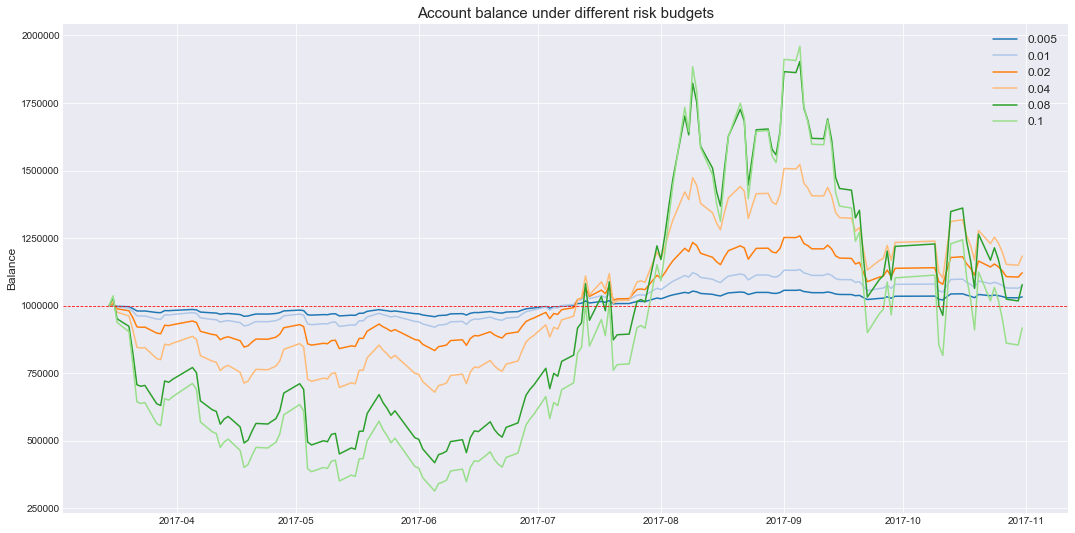

In [25]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(riskBudgetList)):
    ax1.plot(dateList[:-22], balanceDict[riskBudgetList[i]], color = colormap[i], label = riskBudgetList[i])
#     ax1.plot(dateList[:-1], np.array(balanceDict[leverLimitList[i]])/initBalance, color = colormap[i], label = leverLimitList[i])
    # ax1.plot(dateList, balanceList, label = 'Dynamic Betting')
ax1.axhline(y = initBalance, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Balance', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Account balance under different risk budgets', fontsize=15)
plt.show()

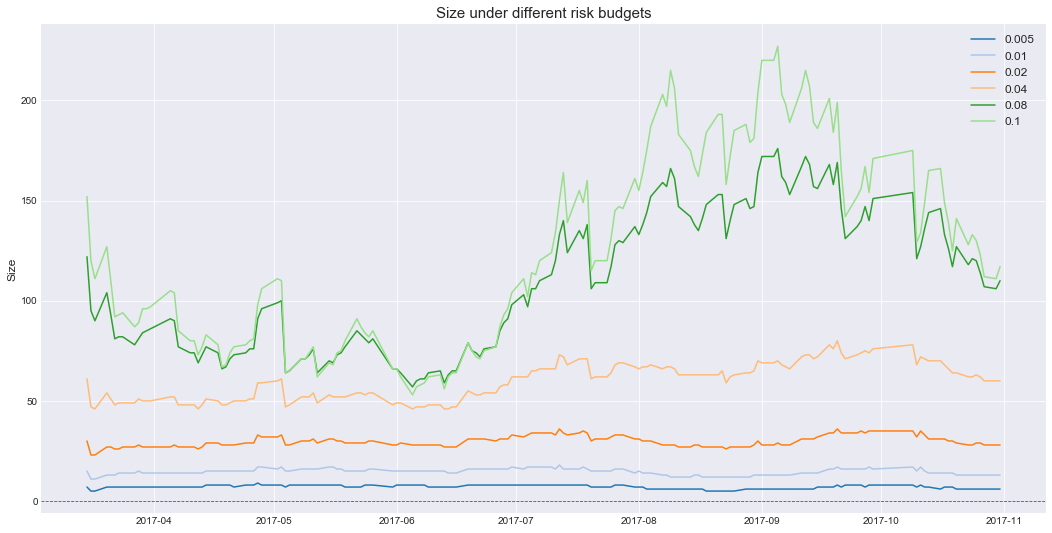

In [26]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(riskBudgetList)):
    ax1.plot(dateList[:-22], sizeDict[riskBudgetList[i]], color = colormap[i], label = riskBudgetList[i])
# ax1.plot(dateList[:-1], leverList, label = 'Dynamic Betting')
ax1.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Size', fontsize = 12)
plt.legend(fontsize = 12)
# ax2 = ax1.twinx()
# ax2.plot(dateList, closeArray, color = 'red')
# ax2.set_ylabel('Price')
plt.title('Size under different risk budgets', fontsize=15)
plt.show()

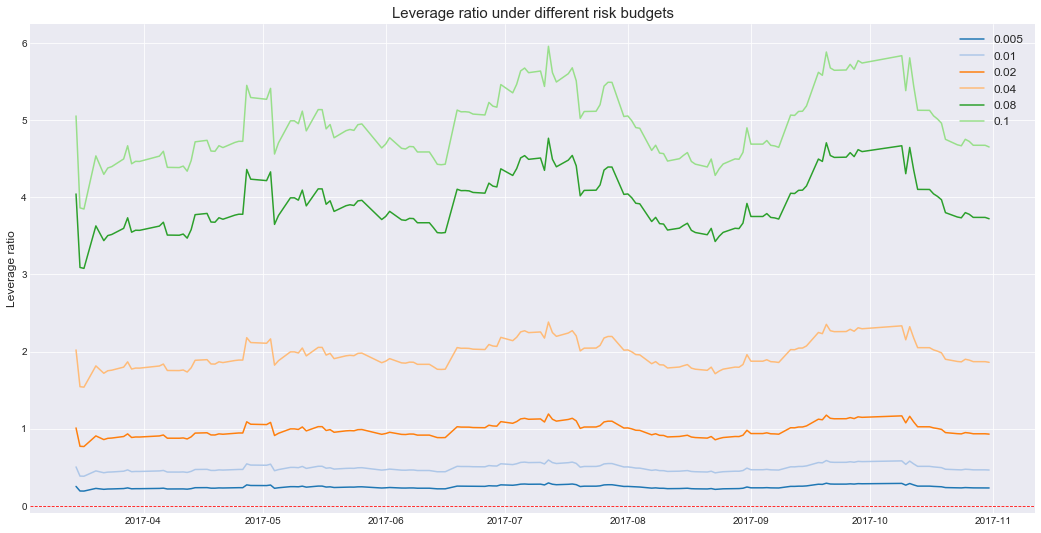

In [27]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(riskBudgetList)):
    ax1.plot(dateList[:-22], leverDict[riskBudgetList[i]], color = colormap[i], label = riskBudgetList[i])
# ax1.plot(dateList[:-1], leverList, label = 'Dynamic Betting')
ax1.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Leverage ratio', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Leverage ratio under different risk budgets', fontsize=15)
plt.show()

In [29]:
# 计算Sharpe ratio
for riskBudget in riskBudgetList:
    retList = [(balanceDict[riskBudget][i] - balanceDict[riskBudget][i-1])/balanceDict[riskBudget][i-1] for i in range(1, len(balanceDict[riskBudget]))]
    sharpe = np.mean(retList)/np.std(retList) * np.sqrt(242)
    print("Sharpe ratio is %.4f when risk budget is %.4f"% (sharpe, riskBudget))

Sharpe ratio is 0.7044 when risk budget is 0.0050
Sharpe ratio is 0.7841 when risk budget is 0.0100
Sharpe ratio is 0.7307 when risk budget is 0.0200
Sharpe ratio is 0.7364 when risk budget is 0.0400
Sharpe ratio is 0.7428 when risk budget is 0.0800
Sharpe ratio is 0.7352 when risk budget is 0.1000


### 情况四：每日计算最优杠杆比率并据此调仓
### 杠杆比率根据凯利公式（Kelly Criterion）计算为 $f = \lambda\frac{\mu}{\sigma^2}$，这里$\lambda$为调整系数，的$\mu$为历史日收益率，$\sigma^2$根据过去windowLength天的日收益率计算,据此调整仓位。

In [30]:
# 杠杆限制
leverLimit = 5
# 每日收益率最大值
maxdailyret = 1
adj_lambda_list = [0.2, 0.4, 0.6, 0.8, 1]
balanceDict = {}
leverDict   = {}
sizeDict    = {}

In [31]:
for adj_lambda in adj_lambda_list:
    currentBalance = initBalance
    retArray = [x for x in initretArray]
    balanceList = []
    leverList   = []
    sizeList    = []
    for i in range(len(closeArray)-22):
        if i == 0:
            # 在策略运行的第一天，以收盘价买入
            currentLever = initLever
            currentSize = np.floor(currentBalance * currentLever/(closeArray[i] * 10))

            stoploss = closeArray[i] * 10 * currentSize * margin

            balanceList.append(currentBalance)
            leverList.append(currentLever)
            sizeList.append(currentSize)

#             print currentBalance, currentSize, currentLever, initmu, initsigma, closeArray[i]
        else:
            # 更新retArray
            ret = (closeArray[i] - closeArray[i-1])/closeArray[i-1]
            retArray[0:windowLength - 1] = retArray[1:windowLength]
            retArray[-1] = ret

            if currentBalance > 0:
                # 计算当前杠杆比率
#                 mu = min((closeArray[-1]/closeArray[i] * 1.0) ** (1.0/len(closeArray[i:])) - 1, maxdailyret)
                mu = (closeArray[-1]/closeArray[i] * 1.0) ** (1.0/len(closeArray[i:])) - 1
                sigma = np.sqrt(np.sum((np.array(retArray) - 0.0)**2) / len(retArray))
                currentLever = mu/sigma ** 2 * adj_lambda
                if currentLever < 0:
                    currentLever = 0
                elif currentLever >= leverLimit:
                    currentLever = leverLimit

                # 计算持仓pnl
                pnl = (closeArray[i] - closeArray[i-1]) * currentSize * 10
                currentBalance += pnl
                stoploss = closeArray[i] * 10 * currentSize * margin

                if currentBalance > stoploss:
                    # 根据当天的currentBalance和杠杆比率调整持仓
                    currentSize = np.floor(currentBalance * currentLever/(closeArray[i] * 10))
                    balanceList.append(currentBalance)
                    sizeList.append(currentSize)
                    leverList.append(currentLever)

                else:
                    # 若当天currentBalance小于stoploss，则currentBalance和size都变为0
                    currentSize = 0
                    currentLever = 0

                    balanceList.append(currentBalance)
                    leverList.append(currentLever)
                    sizeList.append(currentSize)
            else:
                balanceList.append(currentBalance)
                leverList.append(currentLever)
                sizeList.append(currentSize)

#             print currentBalance, currentSize, currentLever, mu, sigma, closeArray[i]
    balanceDict[adj_lambda] = balanceList 
    leverDict[adj_lambda]   = leverList
    sizeDict[adj_lambda]    = sizeList

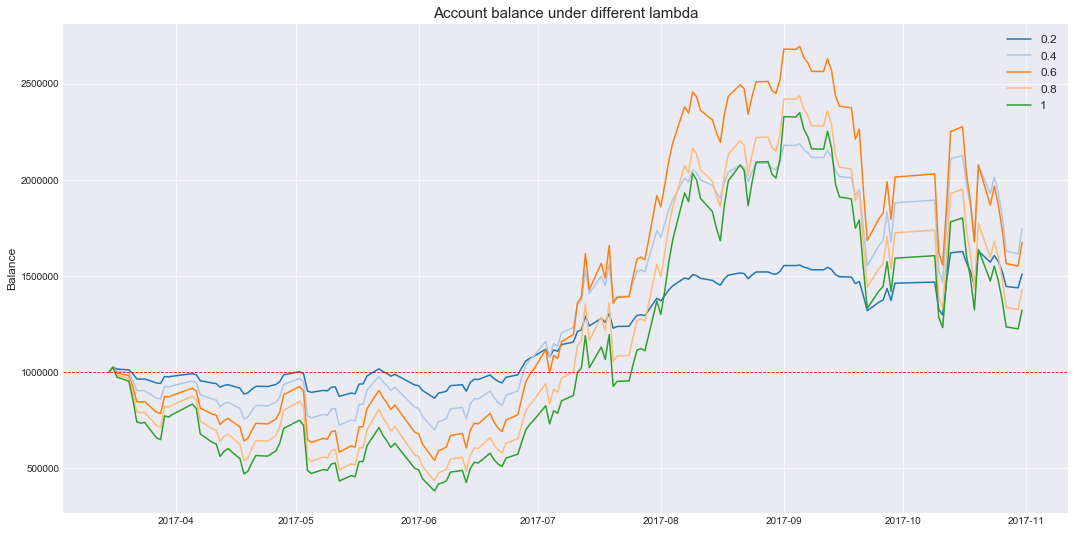

In [32]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(adj_lambda_list)):
    ax1.plot(dateList[:-22], balanceDict[adj_lambda_list[i]], color = colormap[i], label = adj_lambda_list[i])
ax1.axhline(y = initBalance, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Balance', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Account balance under different lambda', fontsize=15)
plt.show()

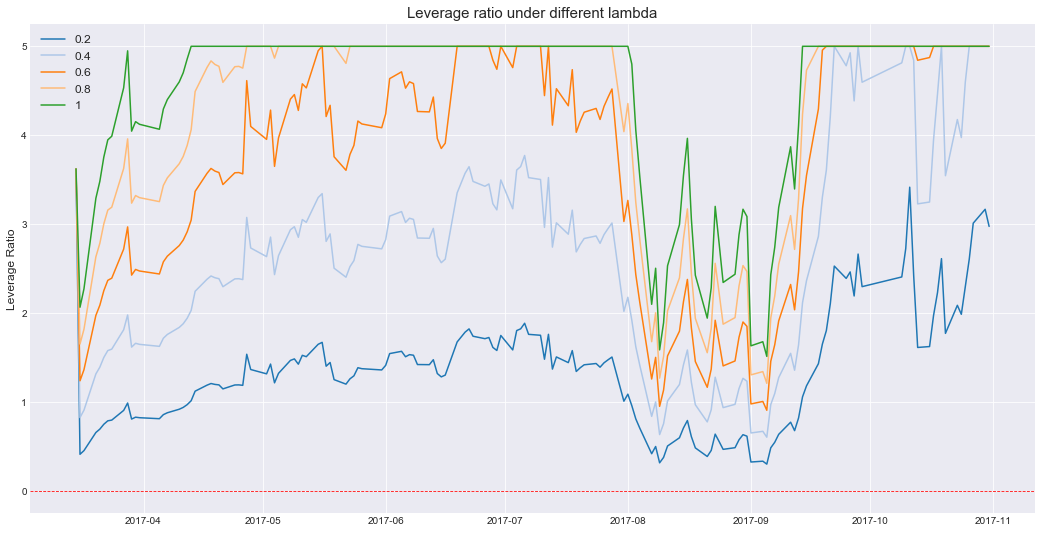

In [33]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(adj_lambda_list)):
    ax1.plot(dateList[:-22], leverDict[adj_lambda_list[i]], color = colormap[i], label = adj_lambda_list[i])
# ax1.plot(dateList[:-1], leverList, label = 'Dynamic Betting')
ax1.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Leverage Ratio', fontsize = 12)
plt.legend(fontsize = 12)
# ax2 = ax1.twinx()
# ax2.plot(dateList, closeArray, color = 'red')
# ax2.set_ylabel('Price')
plt.title('Leverage ratio under different lambda', fontsize=15)
plt.show()

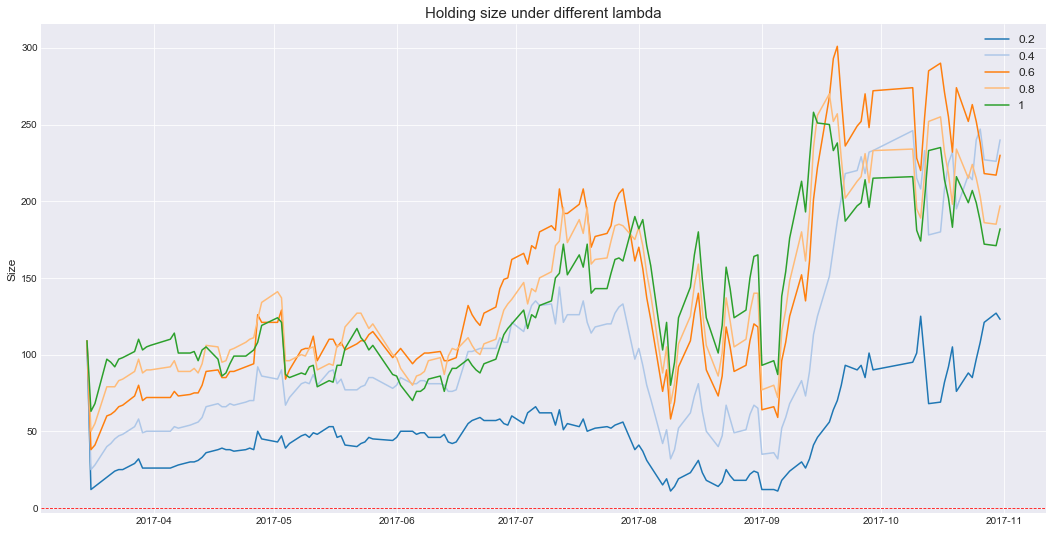

In [34]:
# 画图
fig, ax1 = plt.subplots(figsize=(18, 9))
for i in range(len(adj_lambda_list)):
    ax1.plot(dateList[:-22], sizeDict[adj_lambda_list[i]], color = colormap[i], label = adj_lambda_list[i])
# ax1.plot(dateList[:-1], sizeList, label = 'Dynamic Betting')
ax1.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.8)
ax1.set_ylabel('Size', fontsize = 12)
plt.legend(fontsize = 12)
# ax2 = ax1.twinx()
# ax2.plot(dateList, closeArray, color = 'red')
# ax2.set_ylabel('Price')
plt.title('Holding size under different lambda', fontsize=15)
plt.show()

In [36]:
# 计算Sharpe ratio
for single_lambda in adj_lambda_list:
    retList = [(balanceDict[single_lambda][i] - balanceDict[single_lambda][i-1])/balanceDict[single_lambda][i-1] for i in range(1, len(balanceDict[single_lambda]))]
    sharpe = np.mean(retList)/np.std(retList) * np.sqrt(242)
    print("Sharpe ratio is %.4f when leverage limit is %.2f"% (sharpe, single_lambda))

Sharpe ratio is 1.5528 when leverage limit is 0.20
Sharpe ratio is 1.3896 when leverage limit is 0.40
Sharpe ratio is 1.2820 when leverage limit is 0.60
Sharpe ratio is 1.1178 when leverage limit is 0.80
Sharpe ratio is 1.0432 when leverage limit is 1.00
